In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from torch._tensor import Tensor


style.use("ggplot")

In [2]:
from torch._tensor import Tensor


class GridEnvironmet:
    def __init__(self, width: int, height: int) -> None:
        self.width: int = width
        self.height: int = height
        self.grid: Tensor = torch.zeros((width, height) , dtype=torch.float )
        self.reset()
        pass
    
    def reset(self) -> Tensor:
        self.time_step = 0
        return self.grid

    def step(self, env: torch.Tensor, cov_range: float, con_rage: float) -> tuple[torch.Tensor, float, bool]:
        self.time_step +=1
        agent_count: Tensor = env[env == 1].sum().int()
        rewards: Tensor = self.calc_Reward(self.grid, env, R=cov_range, D = con_rage)
        next_env : torch.Tensor= self._rearrange_sensors(   env,agent_count)
        # self.grid = next_env    
        done :bool = self.time_step >= 360
        return next_env, rewards, done
    
    def _rearrange_sensors(self,output: torch.Tensor, num_sensors:int) -> torch.Tensor:
        flat_output: Tensor = output.view(-1)
        _, indices = torch.topk(flat_output, num_sensors)
        new_grid = torch.zeros_like(flat_output)
        new_grid[indices] = 1
        return new_grid.view_as(output)
    
    def calc_Reward(self,old_env: torch.Tensor , new_env: torch.Tensor, R: float, D: float) -> torch.Tensor:
        # Ensure state is 2D for cdist
        assert new_env.dim() == 2, "State must be 2D for distance calculation"
        assert old_env.dim() == 2, "State must be 2D for distance calculation"
        
        f1: Tensor = F.softplus(old_env , R)
        # f1.requires_grad_()
        f2: Tensor = F.softplus(old_env , D)
        # f2.requires_grad_()
        return f1 + f2

    def get_state(self) -> Tensor:
        return self.grid

In [3]:

class AgentNetWork(nn.Module):
    def __init__(self, state_size, hidden_size=64) -> None:
        super(AgentNetWork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, state_size)

    def forward(self, state: torch.Tensor):
        x: torch.Tensor = F.relu(self.fc1(state))
        x: torch.Tensor = F.relu(self.fc2(x))
        q_values: torch.Tensor = self.fc3(x)
        return q_values

In [4]:
class Agent:
    def __init__(self,
                 id : int ,
                 state_size : torch.Size  ,
                   )->None:
        self.id = id
        self.state_size = state_size
        self.coord:torch.Tensor = torch.tensor(
            ( torch.randint(low=0, high=self.state_size[0] , size=(1,) ) ,
             torch.randint(low=0, high = self.state_size[1], size=(1,)  )
             )
            , dtype=torch.float)
        self.logic:AgentNetWork = AgentNetWork(2)
        self.optim : nn.Module = optim.AdamW ([{"params":self.logic.parameters(),
                                 }], lr=1e-3)
 
    def learn(self, new_coord: torch.Tensor, old_coord: torch.Tensor) -> torch.Tensor:
        self.optim.zero_grad()
        
        new_coord: torch.Tensor = self.logic(old_coord)

        loss = F.mse_loss(self.coord.detach(), old_coord)
        self.coord = new_coord
        loss.backward(retain_graph=True)
        
        self.optim.step()
        
        # return coord



In [5]:
def rearrange_sensors(output, num_sensors) -> torch.Tensor:
    flat_output = output.view(-1)
    _, indices = torch.topk(flat_output, num_sensors)
    new_grid = torch.zeros_like(flat_output)
    new_grid[indices] = 1
    return new_grid.view_as(output)

In [6]:
class MutiAgentSystem:
    def __init__(self,
                 env : GridEnvironmet , 
                 num_agents : int, 
                 coverage_ratio:float, 
                 connection_ratio:float
                 ) -> None:
        
        self.env: GridEnvironmet = env
        self.num_agents: int = num_agents
        self.coverage_ratio: float = coverage_ratio
        self.connection_ratio: float = connection_ratio
        self.agents: list[Agent] = [Agent(id=i,  state_size=env.grid.size()) for i in range(num_agents)]
        self.agents_coordrs = torch.tensor([agent.coord.tolist() for agent in self.agents])
        self.state = self.env.get_state()
        self.reward = torch.zeros((self.state.size(0),self.state.size(1)))
        
        for agent in self.agents:
            self.env.grid[agent.coord[0].int(), agent.coord[1].int()] = 1.

    def step(self,env):
        agents_coordrs = torch.tensor([agent.coord.tolist() for agent in self.agents])
        n, m = self.state.shape
        mapped_coord = ((agents_coordrs + 1) / 2) * torch.tensor([n - 1. ,m - 1. ])
        discrete_env = rearrange_sensors(mapped_coord.round().float()
                                           ,len(agents_coordrs)
                                           )
        # print(discrete_coord)
        agents_coordrs.requires_grad_()
        next_state, rewards, done = self.env.step(env, 
                                                  cov_range=self.coverage_ratio, 
                                                  con_rage=self.connection_ratio)
        self.state = next_state
        coordinates = torch.nonzero(self.env.grid == 1, as_tuple=False).float()
        coordinates.requires_grad_()

        for agent, new_co_ord, old_co_ord in zip(self.agents, discrete_env, coordinates):
            agent.learn(new_co_ord, old_co_ord)
            # agent.coord = new_co_ord

        self.reward += rewards
        # self.agents_coordrs = discrete_env
        return next_state, rewards, done

    
    def _rearrange_sensors(self,output : torch.Tensor, num_sensors: int) -> torch.Tensor:
        flat_output = output.view(-1)
        _, indices = torch.topk(flat_output, num_sensors)
        new_grid = torch.zeros_like(flat_output)
        new_grid[indices] = 1
        return new_grid.view_as(output)
      

In [7]:
def rearrange_sensors(output, num_sensors):
    flat_output = output.view(-1)
    _, indices = torch.topk(flat_output, num_sensors)
    new_grid = torch.zeros_like(flat_output)
    new_grid[indices] = 1
    return new_grid.view_as(output)

In [8]:
env = GridEnvironmet(10,10)
multi_agent = MutiAgentSystem(env=env,
                    num_agents=10,
                    coverage_ratio=.01,
                    connection_ratio=.01)

# first_env: Tensor = env.grid

for run in range(10):
    state = env.reset()
    done = False
    # rewards = 0  # Initialize rewards outside the epoch loop to accumulate rewards across epochs
    while not done:
        next_state, step_reward, done = multi_agent.step(env.grid)
        # rewards += step_reward  # Accumulate step_reward
        # state = next_state
    if run % 10 == 0:
            print(f'Episode | {run} | Return: {step_reward.sum() :.4f} ') 

Episode | 0 | Return: 13871.9668 


In [9]:
def plot_matrix_values(matrix: torch.Tensor):
    # Get the indices where the matrix has values greater than zero (since zero should be ignored in size/color)
    positions = torch.nonzero(matrix >= 0, as_tuple=False)

    # Extract the x and y coordinates and the values at those positions
    x_coords = positions[:, 1]  # Column indices (horizontal axis)
    y_coords = positions[:, 0]  # Row indices (vertical axis)
    values = matrix[y_coords, x_coords]  # The values at these positions

    # Scale marker size based on values; for better visibility, multiply values by a scale factor
    marker_size = values * 200  # Scale factor (adjust as needed)

    # Normalize values to range [0, 1] for color fading
    normalized_values = (values - values.min()) / (values.max() - values.min())

    # Create a scatter plot using seaborn, with size and color based on the values
    plt.figure(figsize=(matrix.size(1)//2 , matrix.size(0)//2 ))
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(10_000, 0),  # Size based on values
                              hue=normalized_values, c="b", marker='o', legend=False,
                              alpha=0.3 )  # Color fading for low values
    scatter = sns.scatterplot(x=x_coords, y=y_coords,
                              size=values, sizes=(100, 0),  # Size based on values
                               c="k", marker='o', legend=False,
                            #   alpha=0.3
                              )
    # Set axis limits and labels
    plt.xlim(-0.5, matrix.size(1) - 0.5)
    plt.ylim(-0.5, matrix.size(0) - 0.5)
    plt.gca().invert_yaxis()  # Invert y-axis to match matrix layout
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.axis("off")
    # plt.title('Area Coverage')
    # Add a colorbar to show the value mapping
    # plt.colorbar(scatter.collections[0], label='Value')
    plt.grid(True)
    plt.show()


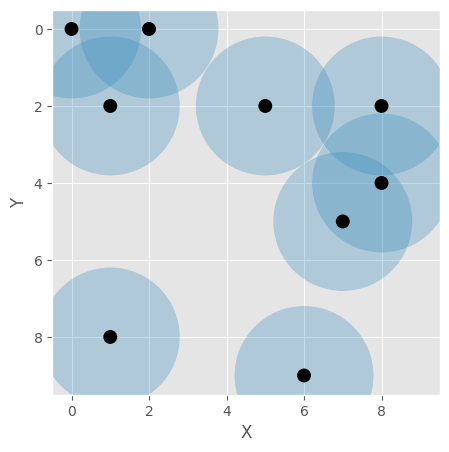

In [10]:
plot_matrix_values(next_state)

In [11]:
next_state

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])